In [1]:
%load_ext autoreload
%autoreload 2

from aeon.datasets import load_classification
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy, MulticlassConfusionMatrix, MulticlassF1Score
import collections
import os

from models import LogisticRegressionWithSummariesAndBottleneck_Wrapper
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [2]:
X, y, meta_data = load_classification("Tiselac", extract_path="/workdir/data")
print(" Shape of X = ", X.shape, type(X), X.dtype)
print(" Shape of y = ", y.shape, type(y), y.dtype)
print(" Meta data = ", meta_data)
y = y.astype(int)
display(y)


 Shape of X =  (99687, 10, 23) <class 'numpy.ndarray'> float64
 Shape of y =  (99687,) <class 'numpy.ndarray'> <U1
 Meta data =  {'problemname': 'tiselac', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2', '3', '4', '5', '6', '7', '8', '9']}


array([6, 1, 6, ..., 3, 4, 5])

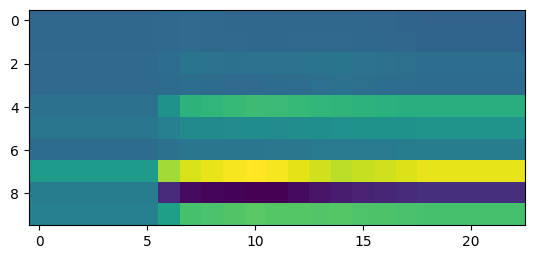

In [3]:
plt.imshow(X[0])

In [4]:
def preprocess_data(_X, _y, batch_size = 4096, random_state = 1):    
    # swap T and V axis
    _X = _X.swapaxes(1,2)
    
    ## target
    _y = _y-1
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    # class weights
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    # split 60/20/20 %
    X_train, X_test, y_train, y_test = train_test_split(_X, _y, test_size = 0.40, random_state = random_state, stratify = _y)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = random_state, stratify = y_test)

    # normalize
    X_train, X_val, X_test = normalize_across_time(X_train, X_val, X_test)

    # tensor
    X_train_pt = torch.tensor(X_train)
    X_train_pt = add_indicators(X_train_pt)
    y_train_pt = torch.tensor(y_train)

    X_val_pt = torch.tensor(X_val)
    X_val_pt = add_indicators(X_val_pt)
    y_val_pt = torch.tensor(y_val)

    X_test_pt = torch.tensor(X_test)
    X_test_pt = add_indicators(X_test_pt)
    y_test_pt = torch.tensor(y_test)
    
    # dataloader
    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4, pin_memory=True)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size = X_test_pt.shape[0], shuffle=False, num_workers=4, pin_memory=True)
    
    
    return train_loader, val_loader, test_loader, weights, num_classes


def add_indicators(data: torch.Tensor):
    indicators_3d = ~torch.isnan(data)
    data = torch.cat([data, indicators_3d], axis=-1) # (N x time_len x 2*changing_dim)
    return data


def normalize_across_time(X_train, X_val, X_test):
    
    scalerX=StandardScaler(with_std=False)
    n_variables = 10
    
    # N x T x V => N*T x V
    X_train_reshaped = X_train.reshape(-1, n_variables)
    X_val_reshaped = X_val.reshape(-1, n_variables)
    X_test_reshaped = X_test.reshape(-1, n_variables)

    nX_train = scalerX.fit_transform(X_train_reshaped)
    nX_val = scalerX.transform(X_val_reshaped)
    nX_test = scalerX.transform(X_test_reshaped)
    
    # revert shape
    nX_train = nX_train.reshape(X_train.shape)
    nX_val = nX_val.reshape(X_val.shape)
    nX_test = nX_test.reshape(X_test.shape)
    
    return nX_train, nX_val, nX_test


In [5]:
train_loader, val_loader, test_loader, weights, num_classes = preprocess_data(X,y)

for a,b in train_loader:
    print(a.shape)
    print(b.shape)
    break

len(train_loader)

torch.Size([4096, 23, 20])
torch.Size([4096])


15

In [6]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()


In [7]:
def initializeModel(n_concepts, input_dim, changing_dim, time_len, output_dim, top_k=''):
    model = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim = input_dim, 
                                                changing_dim = changing_dim, 
                                                time_len = time_len,
                                                num_concepts = n_concepts,
                                                opt_lr = 2e-4,
                                                opt_weight_decay = 2e-05,
                                                l1_lambda=0.001,
                                                cos_sim_lambda=0.01,
                                                output_dim = output_dim,
                                                top_k=top_k,
                                                )
    model = model.to(device)
    return model

## Multi-class

In [8]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/"
model_path = experiment_folder + "tiselac_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

1
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c1.pt
[1, 1.8387020826339722, 0.7006998062133789, 0.2188035249710083, 0.08594749122858047]


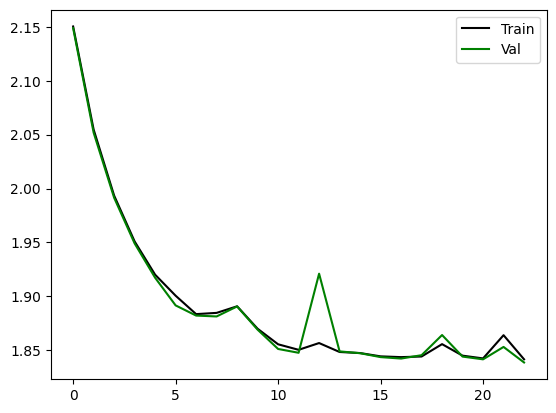

2
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c2.pt
[2, 1.550074815750122, 0.8274151682853699, 0.3691498637199402, 0.23333606123924255]


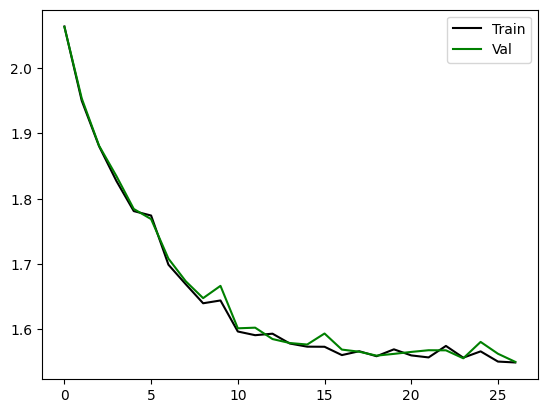

3
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c3.pt
[3, 1.3734240531921387, 0.8709858655929565, 0.4932291507720947, 0.4234181344509125]


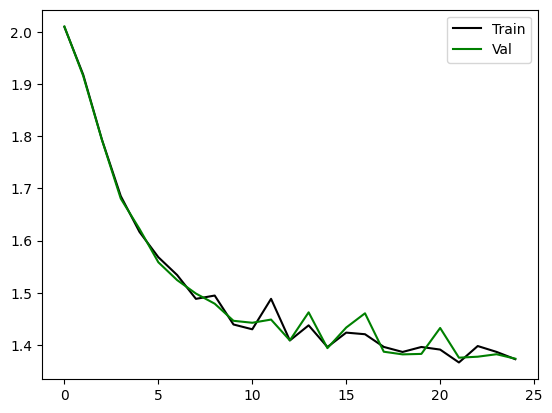

4
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c4.pt
[4, 1.3160028457641602, 0.8876723647117615, 0.5272982120513916, 0.5068289041519165]


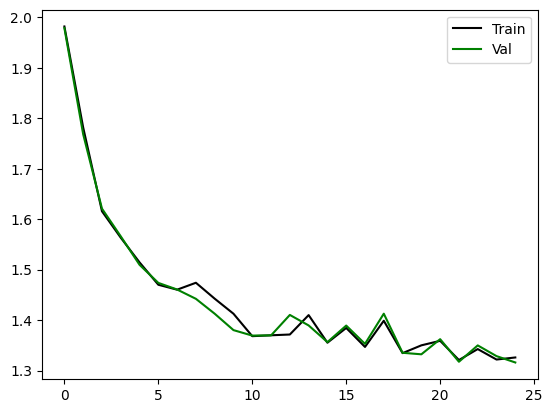

5
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c5.pt
[5, 1.2815232276916504, 0.899220883846283, 0.5694409608840942, 0.5525895953178406]


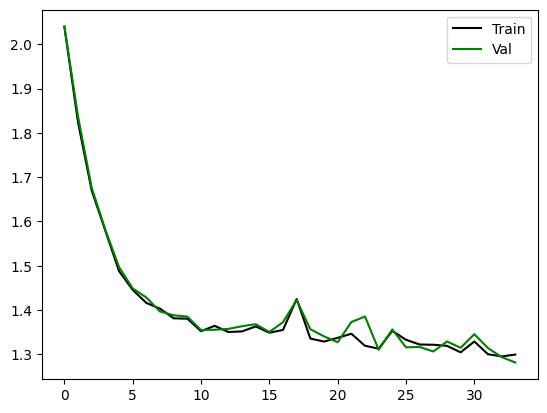

6
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c6.pt
[6, 1.2445869445800781, 0.9039374589920044, 0.5710786581039429, 0.5361932516098022]


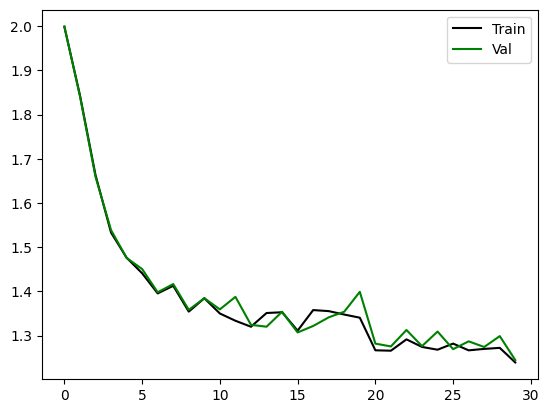

7
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c7.pt
[7, 1.2146025896072388, 0.9066892266273499, 0.5752013921737671, 0.5303741097450256]


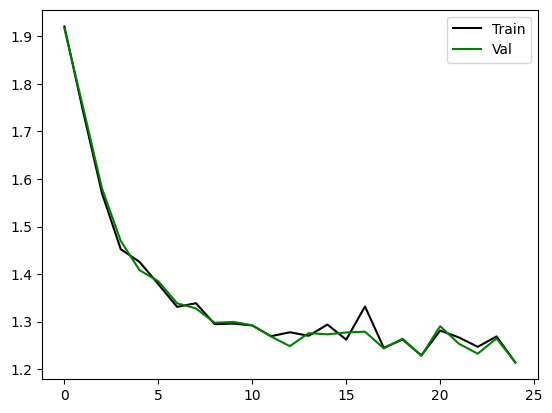

8
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c8.pt
[8, 1.2136154174804688, 0.9102376103401184, 0.5875707864761353, 0.5569881200790405]


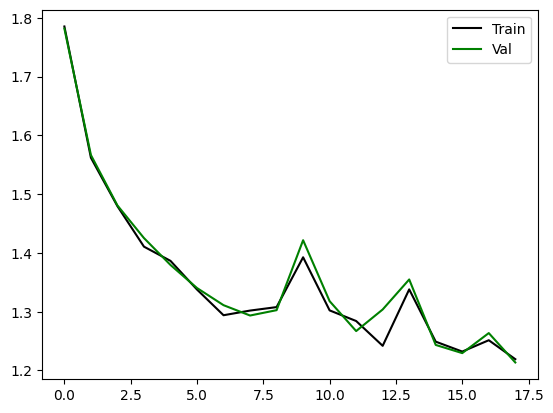

9
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c9.pt
[9, 1.2488042116165161, 0.910709798336029, 0.5678442716598511, 0.531211256980896]


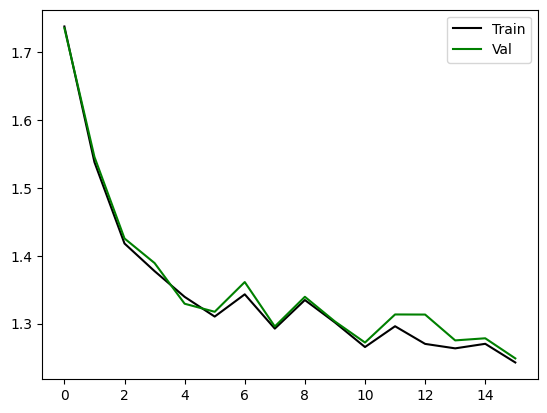

10
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/tiselac/normal/tiselac_c10.pt
[10, 1.1734644174575806, 0.9178282618522644, 0.6173104047775269, 0.5737813711166382]


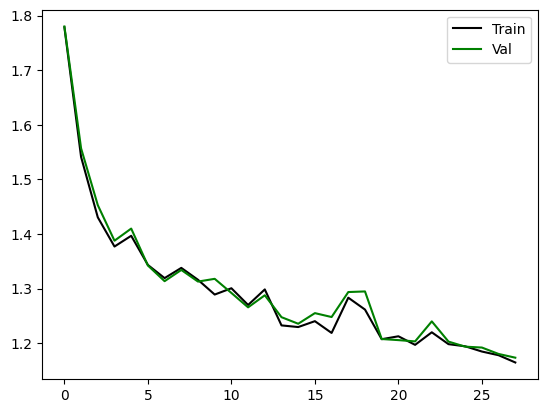

20


 32%|███▏      | 3199/10000 [35:56<1:16:24,  1.48it/s]

Early Stopped


[20, 1.1499725580215454, 0.9302701950073242, 0.6351511478424072, 0.5890228748321533]


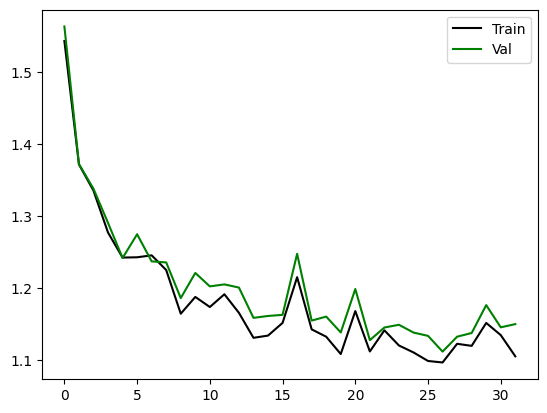

40


 24%|██▍       | 2399/10000 [27:05<1:25:49,  1.48it/s]

Early Stopped


[40, 1.155995488166809, 0.9279912114143372, 0.6209452152252197, 0.5718297958374023]


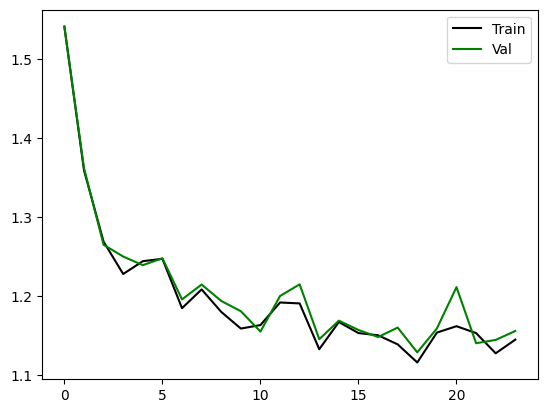

60


 18%|█▊        | 1799/10000 [20:30<1:33:27,  1.46it/s]

Early Stopped


[60, 1.1754947900772095, 0.9252092838287354, 0.6124088764190674, 0.576598584651947]


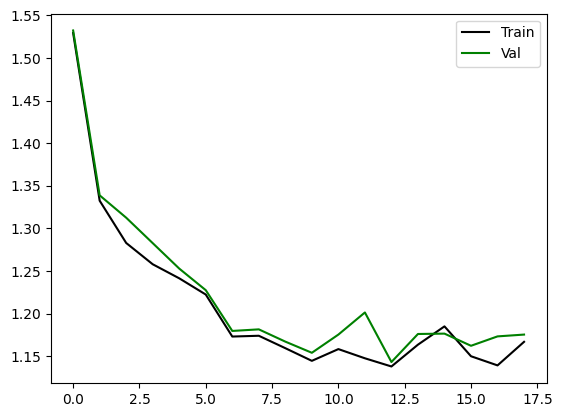

80


 27%|██▋       | 2699/10000 [30:42<1:23:04,  1.46it/s]

Early Stopped


[80, 1.151255488395691, 0.9317324161529541, 0.6297407150268555, 0.5816318988800049]


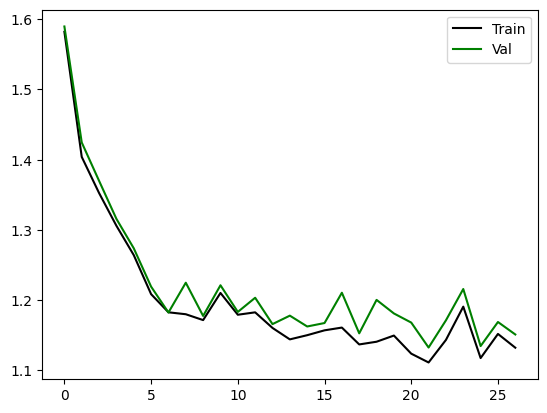

100


 17%|█▋        | 1699/10000 [19:20<1:34:28,  1.46it/s]

Early Stopped


[100, 1.1536062955856323, 0.9305748343467712, 0.6343438029289246, 0.5965290665626526]


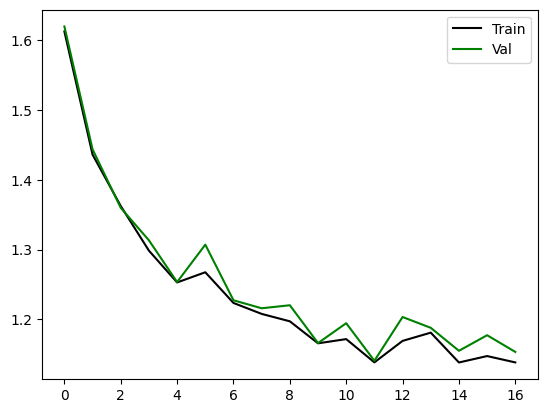

(15, 5)

In [9]:
history_multiclass = []

set_seed(random_seed)

train_loader, val_loader, test_loader, weights, num_classes = preprocess_data(X,y)

changing_dim = X.shape[1]
input_dim = 2 * changing_dim
time_len = X.shape[2]

auroc_metric = MulticlassAUROC(num_classes=num_classes).to(device)
accuracy_metric = MulticlassAccuracy(num_classes=num_classes).to(device)
f1_metric = MulticlassF1Score(num_classes=num_classes).to(device)
conf_matrix = MulticlassConfusionMatrix(num_classes=num_classes).to(device)

n_concepts_list = list(range(1,11)) + list(range(20,101,20))
for n_concepts in n_concepts_list:
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, time_len, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 10000)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            probs = model.forward_probabilities(Xb)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        auroc_metric.reset()
        accuracy_metric.reset()
        conf_matrix.reset()
        f1_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc, f1]
    print(history)
    history_multiclass.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


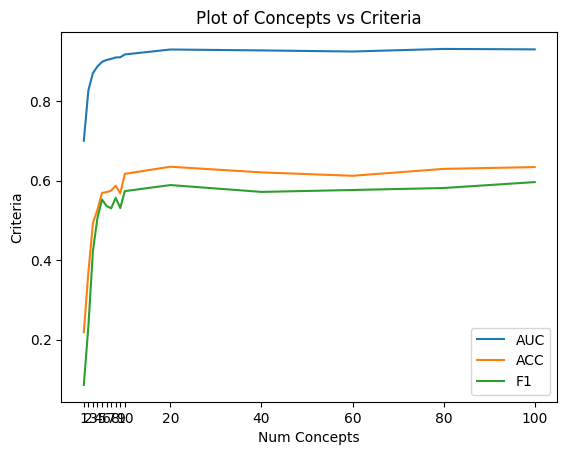

In [11]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 4], label='F1')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(n_concepts_list)

# for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
#     label = "{:.2f}".format(_y)
#     plt.annotate(label, # this is the text
#                  (x,_y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
# for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
#     label = "{:.2f}".format(_y)
#     plt.annotate(label, # this is the text
#                  (x,_y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,-10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center
    
# for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 4]):
#     label = "{:.2f}".format(_y)
#     plt.annotate(label, # this is the text
#                  (x,_y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,-10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, time_len, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for batch_idx, (Xb, yb) in enumerate(test_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    probs = model.forward_probabilities(Xb)
    
    auc = auroc_metric(probs, yb).item()
    acc = accuracy_metric(probs, yb).item()
    conf_matrix(probs, yb)
auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
conf_matrix.plot()
auroc_metric.reset()
accuracy_metric.reset()
conf_matrix.reset()

print("AUC", auc)
print("ACC", acc)

In [ ]:
for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = time_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, time_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()